In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import glob
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score, denoise
from src.sampling_utils import random_step, langevin_step, repulsive_step_parallel
from src.kernel import RBF
from src.embedding import CNN64, CNN16, init_weights

import torch
import torch.nn as nn
import torch.nn.functional as F
# import autograd.numpy as anp
from collections import deque

/data/ap2619/diffusion/score_sde_pytorch/.venv_score/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-13 14:17:36.512261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: module 'triton.language' has no attribute 'constexpr'


In [2]:
# Using 512x512 resolution
model_id = "stabilityai/stable-diffusion-2-base"
# model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"
dtype=torch.float32
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
# pipe = pipe.to(device)
pipe.safety_checker = None
pipe.enable_attention_slicing() # NOTE: 10% slower inference, but big memory savings
# pipe.enable_sequential_cpu_offload() # NOTE: May slow down inference a lot
pipe.enable_vae_slicing() # TODO: Try to give batches to VAE
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

# Traced UNet? https://huggingface.co/docs/diffusers/optimization/fp16

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 11426.23it/s]


In [78]:
# Settings
prompt = ["person face smiling"]#["beautiful tree"]
config = {
    "pipe": pipe,
    "height": 512,
    "width": 512,
    "num_inference_steps": 20,
    "num_train_timesteps": 1000,
    "batch_size": 1,
    "cfg": 8,
    "beta_start": 0.00085,
    "beta_end": 0.012,
}

# Seeds
seed=1024
generator = torch.Generator(device).manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(0)
random.seed(0)

# Noise levels
sigmas, timesteps = get_sigmas(config, device=device)
init_latents, text_embeddings = get_score_input(prompt, config, generator=generator, device=device, dtype=dtype)
config = {**config,
          "sigmas": sigmas,
          "timesteps": timesteps,
          "init_latents": init_latents,
          "text_embeddings": text_embeddings
          }

In [79]:
latent = denoise([1], 0, config, return_all_samples=False, generator=generator)

100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


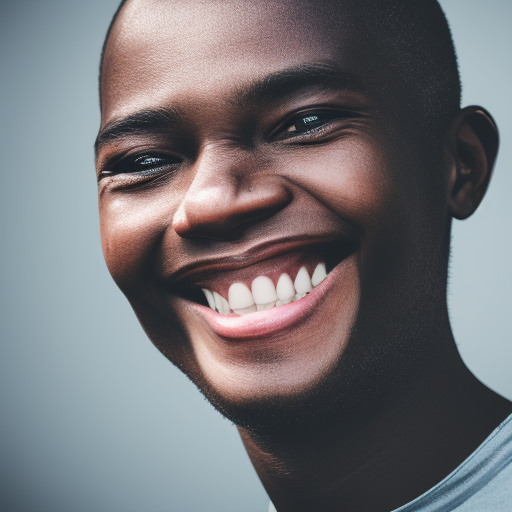

In [80]:
# Plot image results
image = output_to_img(decode_latent(latent, config['pipe'].vae))
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [ ]:
# Exporting model to onnx
x = torch.randn_like(latent)
torch.onnx.export(pipe.vae.decoder, x.cpu(), 'vae.onnx', input_names=["latent"], output_names=["image"], operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK)

Particles

In [5]:
# path = "model16.pt"
# net = CNN16()
path = "model.pt"
net = CNN64()
save_weights = False

if save_weights:
    # Initialise weights
    net.apply(init_weights)
    # Store weights and model
    torch.save(net.state_dict(), path)

# Load model instead of re-initialising
net.load_state_dict(torch.load(path))
net.to(torch.device("cuda"))

CNN64(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (act): ReLU()
)

In [81]:
def repulsive_step_parallel(
        particles,
        scores,
        phi_history,
        model,
        K,
        generator,
        add_noise = True,
        step_size=0.2,
        snr=1, # strength of repulsive term
        device="cuda",
    ):
        """ Take repulsive langevin step. 
            particles: list of latent samples
            scores: list of scores for each latent sample
            phi_history: List of previous phi particles used
            model: embedding model for latents to smaller dim space
            K: Kernel function
        
        """
        grads = []
        for particle in particles:
            # Embed latent to smaller dimension
            phi = model(particle)
            phi_history.append(phi)

            # Compute gradient ∇_latent (phi) for pushforward gradient computation
            grad = torch.autograd.functional.jacobian(
                model, 
                particle.clone().detach().requires_grad_()
            )
            grads.append(grad)

        # Compute kernel gradients
        tphis = torch.stack(list(phi_history),axis=0)
        # Set bandwidth of RBF kernel with median heuristic
        K.bandwidth(tphis, tphis)
        print(f"Sigma: {K.sigma.item()}")
        # Kernel grad shape: embedding_size x num_particles x num_particles
        kernel_grad = K.grad_first(tphis, tphis)
        kernel_grad_sum = torch.sum(kernel_grad, axis=-1)

        # Repulsive term
        nparticles = len(particles)
        new_particles = []
        for i in range(nparticles):
            # Pushforward/Chain rule
            # TODO: Check this multiplication is right
            repulsive = torch.einsum('i,ijklm->jklm',kernel_grad_sum[:,i-nparticles], grads[i]) / nparticles

            # (debug) Get repulsion norm
            repulsive_norm = torch.norm(repulsive.reshape(repulsive.shape[0], -1), dim=-1).mean()
            score_norm = torch.norm(scores[i].reshape(scores[i].shape[0], -1), dim=-1).mean()
            repulsive_scale = snr * score_norm / repulsive_norm
            print(repulsive_norm.item())

            # (debug) Save repulsion term
            # torch.save(repulsive, f'repulsive{i}.pt')

            # Score + Repulsion
            new_particle = particles[i] + step_size * (scores[i] - 100*repulsive)
            # ONLY Repulsion
            # new_particle = particles[i] - step_size * (repulsive_scale * repulsive)
            if add_noise:
                noise = torch.randn(particles[i].shape, layout=particles[i].layout, device=device, generator=generator).to(device)
                new_particle += ((step_size * 2) ** 0.5) * noise

            new_particles.append(new_particle)
        return new_particles

In [82]:
# Repulsion in series
def get_phi_grad(particle, model):
    # Get (phi, ∇_latent (phi))
    # Embed latent to smaller dimension
    phi = model(particle)
    # Compute gradient ∇_latent (phi) for pushforward gradient computation
    grad = torch.autograd.functional.jacobian(
        model, 
        particle.clone().detach().requires_grad_()
    )
    return (phi, grad)


def repulsive_step(
        particle,
        score,
        phi_history,
        model,
        K,
        generator,
        add_noise = False,
        step_size=0.2,
        snr=100, # strength of repulsive term
        device="cuda",
    ):
        """ Take repulsive langevin step. 
            particles: list of latent samples
            scores: list of scores for each latent sample
            phi_history: List of previous phi particles and their gradients
            model: embedding model for latents to smaller dim space
            K: Kernel function
        
        """
        # Compute kernel gradients
        tphis = torch.stack([phi_grad[0] for phi_grad in phi_history],axis=0)
        # Set bandwidth of RBF kernel with median heuristic
        K.bandwidth(tphis, tphis)
        print(f"Sigma: {K.sigma.item()}")
        # Kernel grad shape: embedding_size x num_particles x num_particles
        kernel_grad = K.grad_first(tphis, tphis)
        kernel_grad_sum = torch.sum(kernel_grad, axis=-1)

        # Repulsive term
        # Pushforward/Chain rule for last particle added
        repulsive = torch.einsum('i,ijklm->jklm',kernel_grad_sum[:,-1], grad)

        # (debug) Get repulsion norm
        repulsive_norm = torch.norm(repulsive.reshape(repulsive.shape[0], -1), dim=-1).mean()
        score_norm = torch.norm(repulsive.reshape(score.shape[0], -1), dim=-1).mean()
        repulsive_scale = snr * score_norm / repulsive_norm
        print(repulsive_norm.item())

        # (debug) Save repulsion term
        # torch.save(repulsive, f'repulsive{i}.pt')

        # Score + Repulsion
        # new_particle = particles[i] + step_size * (scores[i] + repulsive_scale * repulsive)
        # ONLY Repulsion
        new_particle = particle + step_size * (repulsive_scale * repulsive)
        if add_noise:
            noise = torch.randn(particle.shape, layout=particle.layout, device=device, generator=generator).to(device)
            new_particle += ((step_size * 2) ** 0.5) * noise

        return new_particle

In [83]:
# Testing: Comparing distance between particle latents
def compare_particles(init_particles, particles, model):
    # L2 distance between initial and evolved particles in SD2 latent space and model embedding latent space
    n = len(init_particles)
    sd_diff = 0
    emb_diff = 0
    for i in range(n):
        sd_diff += torch.mean((init_particles[i]-particles[i])**2)
        emb_diff += torch.mean((model(init_particles[i]) - model(particles[i]))**2)
    
    sd_diff/=n
    emb_diff/=n
    print(f"SD2 L2 distance: {sd_diff}")
    print(f"Embedding L2 distance: {emb_diff}")

def spread(particles):
    # Get L2 distances between particles
    spread=0
    n = len(particles)
    for i in range(n):
        for j in range(i+1,n):
            spread += torch.mean((particles[i]-particles[j])**2)
    
    return spread

In [108]:
# Particle diffusion
def correct_particles(
    particles,
    sigma,
    t,
    correction_steps,
    correction_method,
    config,
    generator,
    step_size=0.2,
    model=None,
    kernel=None,
    phi_history_size=20
    ):
    """ At certain noise scale (step t), apply correction steps to all particles
        particles: N particles in the diffusion process
        method (str): type of correction step "random", "langevin", "score", or "repulsive"
        model: Embedding model (must be defined if repulsive correct_type specified)
        K: RBF Kernel (must be defined if repulsive correct_type specified)
        TODO: Make sampler factory class
    """
    if correction_method=="random":
        new_particles = random_step(particles, correction_steps, generator, step_size=step_size)
    elif correction_method=="repulsive":
        # Parallel particles
        phi_history = deque([], phi_history_size)
        for i in range(correction_steps):
            scores = [get_score(particle, sigma, t, config) for particle in particles]
            particles = repulsive_step_parallel(particles, scores, phi_history, model, kernel, generator, step_size=step_size)
            print(f"Correction {i} spread: SD - {spread(particles)} embedding - {spread([model(particle) for particle in particles])}")
        new_particles = particles

    elif correction_method=="repulsive_series":
        # WIP: Update particles one at a time
        phi_history = deque([], phi_history_size)

        # Add particles 
        for particle in particles:
            phi_grad = get_phi_grad(particle, model)
            phi_history.append(phi_grad)

        for i in range(correction_steps):
            for n in range(len(particles)):
                score = get_score(particles[n], sigma, t, config)
                particles[n] = repulsive_step(particles[n], scores, phi_grad, phi_history, model, kernel, generator, step_size=step_size)
                print(f"Correction {i} spread: SD - {spread(particles)} embedding - {spread([model(particle) for particle in particles])}")
        new_particles = particles

    elif correction_method=="langevin" or correction_method=="score":
        new_particles = []
        add_noise = (correction_method=="langevin")
        for particle in particles:
            for _ in range(correction_steps):
                score = get_score(particle, sigma, t, config)
                particle = langevin_step(particle, score, generator, step_size=step_size, add_noise=add_noise)
            new_particles.append(particle)
    else:
        print(f"ERROR: Correction step type: '{correction_method}' not implemented yet")
            
    return new_particles

def denoise_particles(
    config,
    generator,
    correction_levels=[],
    correction_steps=1,
    correction_step_size=0.2,
    correction_method="langevin",
    addpart_level=0,
    addpart_steps=1,
    addpart_step_size=0.2,
    addpart_method="langevin",
    num_particles=1,
    model=None,
    kernel=RBF(),
    device="cuda",
):
    """ General function to take steps and add particles at different noise levels of diffusion
        correction_levels (int or List[int]): noise level indices to do correction steps in
        correction_steps (int or List[int]): number of correction steps to take in each noise level
        correction_method (str or List[str]): method of correction e.g. random, langevin, score 
        addpart_level (int): noise level index to add particles in
        addpart_steps (int): number of steps taken between particles
        addpart_method (str): method of steps for adding particles e.g. random, langevin, score (NOT repulsive)
        config (Dict): info for diffusion
        generator: RNG generator - reset before calling this method
        num_particles=2: number of particles to add at addpart_level
        Model: Embedding model for repulsion
        model_path: path to embedding model weights
        Kernel=RBF: Kernel class to use for repulsive steps
        device="cuda",
    """
    if addpart_method=="repulsive":
        print("Cannot use repulsive steps to add new particles.")
        return None
    # standard deviation of the initial noise distribution
    sigmas = config['sigmas']
    latents = config['init_latents'] * sigmas.max()

    particles = [latents]
    for i, t in enumerate(tqdm(config['timesteps'])):
        t = t.to(device)
        step_index = (config['timesteps'] == t).nonzero().item()
        sigma = sigmas[step_index]

        # Create particles
        if i==addpart_level:
            for _ in range(num_particles-1):
                new_particle = correct_particles(
                    [particles[-1]], 
                    sigma, 
                    t, 
                    correction_steps=addpart_steps, 
                    correction_method=addpart_method, 
                    config=config, 
                    generator=generator, 
                    step_size=addpart_step_size, 
                    model=model, 
                    kernel=kernel
                )
                particles.append(new_particle[0])
            print(f"Initial spread: SD - {spread(particles)} embedding - {spread([model(particle) for particle in particles])}")
        
        # Correction steps
        if i in correction_levels:
            particles = correct_particles(
                particles, 
                sigma, 
                t, 
                correction_steps, 
                correction_method=correction_method, 
                config=config, 
                generator=generator, 
                step_size=correction_step_size, 
                model=model, 
                kernel=kernel
            )
        
        # Move to next marginal in diffusion
        for n in range(len(particles)):
            score = get_score(particles[n], sigma, t, config)
            particles[n] = step_score(particles[n], score, sigmas, step_index)
    
    return particles

In [112]:
sigmas

tensor([14.6146, 10.7468,  8.0815,  6.2050,  4.8557,  3.8654,  3.1238,  2.5572,
         2.1157,  1.7648,  1.4806,  1.2458,  1.0481,  0.8784,  0.7297,  0.5964,
         0.4736,  0.3555,  0.2322,  0.0292,  0.0000], device='cuda:0')

In [85]:
class Average(nn.Module):
    def forward(self, x):
        return torch.mean(x).reshape(1)

class AverageDim(nn.Module):
    def forward(self, x):
        return torch.mean(x, axis=(0,2,3))

class SoftBoundedAverage(nn.Module):
    def forward(self, x):
        # torch.tanh or torch.sigmoid
        return torch.tanh(torch.mean(x)).reshape(1)

class HardBoundedAverage(nn.Module):
    def forward(self, x):
        # TODO
        return torch.tanh(torch.mean(x)).reshape(1)

class VAEAverage(nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae
    
    def forward(self, latents):
        latents = 1 / self.vae.config.scaling_factor * latents
        image = self.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        return image.mean(axis=(0,2,3))
        

In [110]:
seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
# Embedding model for repulsive force
# model = CNN16(relu=False)
# model_path = "model16.pt"
# model.load_state_dict(torch.load(model_path))
# model.to(torch.device("cuda"))
# model=VAEAverage(vae=pipe.vae)
model=AverageDim()
# model=SoftBoundedAverage()
# Denoise
particles = denoise_particles(config, generator, num_particles=1, correction_levels=range(20), correction_steps=20, correction_step_size=0.2,
                                correction_method="langevin", model=model)

  0%|          | 0/20 [00:00<?, ?it/s]

Initial spread: SD - 0 embedding - 0


100%|██████████| 20/20 [01:49<00:00,  5.49s/it]


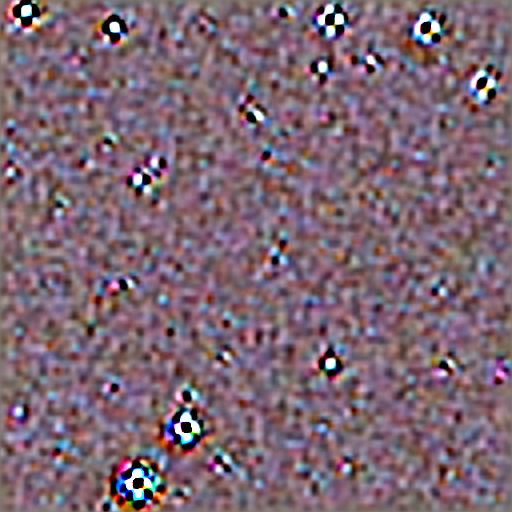

In [111]:
# Plot image results
# Plot list of decoded latents
visualise_latent_list = particles

pil_images = []
for l in visualise_latent_list:
    image = output_to_img(decode_latent(l, pipe.vae))
    images = (image * 255).round().astype("uint8")
    pil_images.append([Image.fromarray(image) for image in images][0])

grid = image_grid(pil_images,1,len(visualise_latent_list))
grid

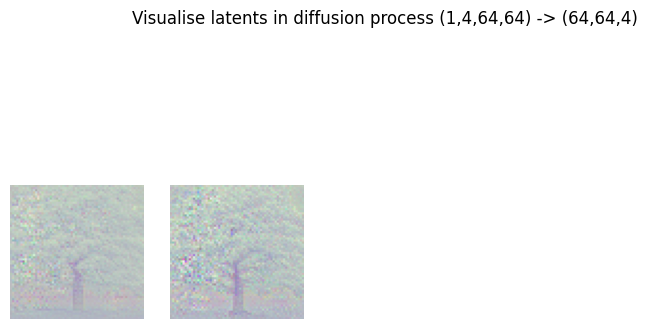

In [28]:
visualise_latent_list = particles

import matplotlib.pyplot as plt
lats = latent_to_img(visualise_latent_list)
plt.figure(figsize=(10,5))
plt.suptitle("Visualise latents in diffusion process (1,4,64,64) -> (64,64,4)")
for i, lat in enumerate(lats):
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(lat)

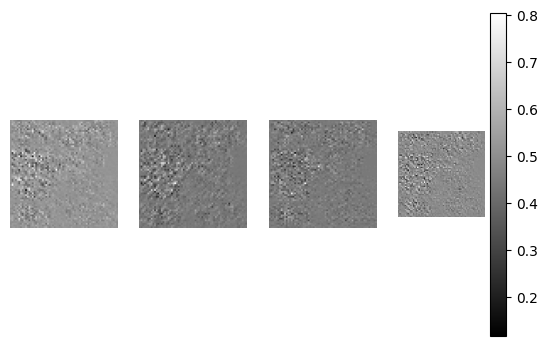

In [51]:
# Plot repulsive term
repulsive = torch.load('repulsive3.pt')
lat = latent_to_img([repulsive])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.imshow(lat[0][...,i], cmap='gray')
plt.colorbar()

In [33]:
repulsive

tensor([[[[ 9.2832e-04,  4.5789e-03,  2.6533e-04,  ..., -2.9138e-03,
            3.6366e-04,  1.9170e-03],
          [-1.8788e-04,  2.7751e-03, -2.7535e-03,  ...,  3.3567e-03,
           -6.2588e-03,  6.5956e-03],
          [ 4.3384e-04, -7.9534e-04,  3.2360e-03,  ..., -1.6692e-03,
            1.2745e-04,  6.0662e-03],
          ...,
          [ 3.4474e-05, -5.3542e-03,  5.6124e-04,  ..., -9.0950e-03,
           -1.5915e-03, -5.8526e-05],
          [-7.8929e-04, -4.0249e-03,  1.1507e-03,  ..., -1.2887e-04,
           -2.8203e-03, -2.2863e-03],
          [ 5.5013e-03, -1.7029e-03, -3.7889e-03,  ..., -3.0377e-03,
            1.7352e-03, -3.0281e-03]],

         [[ 1.0522e-03,  1.7171e-05, -1.4525e-03,  ..., -2.2544e-04,
            1.8536e-03,  1.7626e-03],
          [-1.3582e-03, -5.1985e-03,  1.9834e-03,  ..., -5.1391e-03,
            8.6768e-03,  2.2434e-03],
          [-9.7662e-04, -4.5187e-03,  9.0732e-04,  ...,  1.6637e-04,
            4.8782e-03,  1.4940e-03],
          ...,
     

In [20]:
lat[0].shape

torch.Size([64, 64, 4])

In [15]:
grid.save("experiments/test.png")

In [ ]:
# Plot repulsive norms
with open('out.txt') as f:
    lines = f.readlines()
norms = [float(line.split()[0]) for line in lines]
plt.plot(norms[::2], label="particle 1")
plt.plot(norms[1::2], label="particle 2")
plt.legend()
plt.ylabel("Repulsive term magnitude")
plt.xlabel("Steps")

In [14]:
import os, glob
for file in glob.glob("data/denoise_results/*/*/*"):
    new_file_name = file[:-25]+"0_stepseed"+file[-25:-6]+"_"+file[-5:]
    os.rename(file, new_file_name)

In [13]:
a = "data/denoise_results/langevin/a_black_cat/lvl12_seed4_nsteps100_stepsz0.1.png"
a[:-25]+"0_stepseed"+a[-25:-6]+"_"+a[-5:]

'data/denoise_results/langevin/a_black_cat/lvl12_seed0_stepseed4_nsteps100_stepsz0_1.png'

In [18]:
torch.mean((particles[1]-particles[2])**2) #0.2674

tensor(0.4009, device='cuda:0', grad_fn=<MeanBackward0>)

Saving images

In [ ]:
import os, glob
import imageio.v3 as iio
for seed in range(2):
    for lvl in [1]:
        rows = []
        for file in glob.glob(f"data/denoise_results/langevin/a_black_cat_seed{seed}/lvl{lvl}_*"):
            rows.append(iio.imread(file))
        plt.figure(figsize=(20,20))
        plt.axis('off')
        plt.imshow(np.concatenate(rows, axis=0))
        name = f'langevin_lvl{seed}_seed{lvl}_nsteps100_stepsz0_1'
        plt.title(name)
        plt.savefig(f'data/denoise_results/langevin/collage/{name}.png')

In [15]:
os.path.basename(file)

'lvl0_seed0_stepseed13_nsteps100_stepsz0_1.png'

In [ ]:
# plot score
for seed in range(2):
    rows = []
    for file in glob.glob(f"data/denoise_results/score/a_black_cat_seed{seed}/*"):
        rows.append(iio.imread(file))
    plt.figure(figsize=(20,20))
    plt.axis('off')
    plt.imshow(np.concatenate(rows, axis=0))
    name = f'score_seed{seed}_nsteps100_stepsz0_1'
    plt.title(name)
    plt.savefig(f'data/denoise_results/score/collage/{name}.png')